## user_segmentation

User Segmentation Analysis for Subscription Analytics Platform
- Dataset: AWS SaaS Sales Data from Kaggle

### 1: Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_style("whitegrid")
sns.set_palette("husl")

### 2: Load and Explore the Dataset

In [4]:
# Load the AWS SaaS sales dataset
df = pd.read_csv('../data/raw/saas_sales.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nFirst 5 rows:")
print(df.head())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Basic statistics
print("\nDataset Info:")
print(df.info())

Dataset Shape: (9994, 19)

Column Names:
['Row ID', 'Order ID', 'Order Date', 'Date Key', 'Contact Name', 'Country', 'City', 'Region', 'Subregion', 'Customer', 'Customer ID', 'Industry', 'Segment', 'Product', 'License', 'Sales', 'Quantity', 'Discount', 'Profit']

First 5 rows:
   Row ID          Order ID  Order Date  Date Key    Contact Name  \
0       1  EMEA-2022-152156   11/9/2022  20221109     Nathan Bell   
1       2  EMEA-2022-152156   11/9/2022  20221109     Nathan Bell   
2       3  AMER-2022-138688   6/13/2022  20220613  Deirdre Bailey   
3       4  EMEA-2021-108966  10/11/2021  20211011      Zoe Hodges   
4       5  EMEA-2021-108966  10/11/2021  20211011      Zoe Hodges   

         Country           City Region Subregion           Customer  \
0        Ireland         Dublin   EMEA      UKIR            Chevron   
1        Ireland         Dublin   EMEA      UKIR            Chevron   
2  United States  New York City   AMER     NAMER        Phillips 66   
3        Germany      S

### 3: Data Preprocessing and Feature Engineering

In [7]:
# Check the actual column structure
print("\nOriginal columns in the dataset:")
print(df.columns.tolist())
print("\nSample data types:")
print(df.dtypes)

# Let's examine the first few rows to understand the data structure
print("\nFirst few rows of actual data:")
print(df.head())


Original columns in the dataset:
['Row ID', 'Order ID', 'Order Date', 'Date Key', 'Contact Name', 'Country', 'City', 'Region', 'Subregion', 'Customer', 'Customer ID', 'Industry', 'Segment', 'Product', 'License', 'Sales', 'Quantity', 'Discount', 'Profit']

Sample data types:
Row ID            int64
Order ID         object
Order Date       object
Date Key          int64
Contact Name     object
Country          object
City             object
Region           object
Subregion        object
Customer         object
Customer ID       int64
Industry         object
Segment          object
Product          object
License          object
Sales           float64
Quantity          int64
Discount        float64
Profit          float64
dtype: object

First few rows of actual data:
   Row ID          Order ID  Order Date  Date Key    Contact Name  \
0       1  EMEA-2022-152156   11/9/2022  20221109     Nathan Bell   
1       2  EMEA-2022-152156   11/9/2022  20221109     Nathan Bell   
2       3  AMER

#### 3.1: Standardize Column Names

In [8]:
# Create a function to clean and standardize column names
def standardize_column_names(df):
    """
    Standardize column names to lowercase with underscores
    """
    # Create a copy to avoid modifying original
    df_clean = df.copy()
    
    # Convert column names to lowercase and replace spaces with underscores
    df_clean.columns = df_clean.columns.str.lower().str.replace(' ', '_').str.replace('-', '_')
    
    # Remove special characters and multiple underscores
    df_clean.columns = df_clean.columns.str.replace('[^a-z0-9_]', '', regex=True)
    df_clean.columns = df_clean.columns.str.replace('_{2,}', '_', regex=True)
    
    # Remove leading/trailing underscores
    df_clean.columns = df_clean.columns.str.strip('_')
    
    return df_clean

# Apply column standardization
df = standardize_column_names(df)

print("\nStandardized columns:")
print(df.columns.tolist())


Standardized columns:
['row_id', 'order_id', 'order_date', 'date_key', 'contact_name', 'country', 'city', 'region', 'subregion', 'customer', 'customer_id', 'industry', 'segment', 'product', 'license', 'sales', 'quantity', 'discount', 'profit']


#### 3.2: Create Column Mapping Dictionary

In [9]:
# Map common business terms to standardized column names
column_mapping_rules = {
    'customer_id': ['customer_id', 'customerid', 'customer', 'client_id', 'clientid', 'user_id', 'userid'],
    'revenue': ['revenue', 'amount', 'price', 'total_amount', 'sales', 'income', 'value'],
    'subscription_fee': ['subscription_fee', 'subscription', 'plan_fee', 'monthly_fee', 'fee', 'subscription_amount'],
    'usage_hours': ['usage_hours', 'usage', 'hours', 'time_spent', 'session_time', 'active_time'],
    'support_tickets': ['support_tickets', 'tickets', 'issues', 'support_requests', 'help_requests'],
    'login_frequency': ['login_frequency', 'logins', 'sessions', 'visits', 'frequency'],
    'order_date': ['order_date', 'date', 'created_date', 'subscription_date', 'start_date'],
    'product': ['product', 'service', 'plan', 'package', 'offering'],
    'region': ['region', 'location', 'country', 'area', 'territory'],
    'industry': ['industry', 'sector', 'vertical', 'business_type']
}

# Function to find matching column for each business concept
def find_matching_column(df_columns, possible_names):
    """
    Find the first matching column name from a list of possibilities
    """
    for col in df_columns:
        if col in possible_names:
            return col
    return None

# Create actual column mapping
actual_column_mapping = {}
for business_term, possible_names in column_mapping_rules.items():
    matched_col = find_matching_column(df.columns, possible_names)
    if matched_col:
        actual_column_mapping[business_term] = matched_col

print(f"\nActual column mapping found: {actual_column_mapping}")


Actual column mapping found: {'customer_id': 'customer', 'revenue': 'sales', 'order_date': 'order_date', 'product': 'product', 'region': 'country', 'industry': 'industry'}


#### 3.3: Handle Missing Critical Columns

In [10]:
# Ensure we have a customer identifier
if 'customer_id' not in actual_column_mapping:
    # Look for any column that might be an ID
    id_candidates = [col for col in df.columns if 'id' in col or col.startswith('customer') or col.startswith('client')]
    if id_candidates:
        actual_column_mapping['customer_id'] = id_candidates[0]
        print(f"Using '{id_candidates[0]}' as customer identifier")
    else:
        # Create synthetic customer ID based on unique combinations
        df['customer_id'] = range(len(df))
        actual_column_mapping['customer_id'] = 'customer_id'
        print("Created synthetic customer_id column")

# Verify we have the essential customer_id column
print(f"\nFinal customer ID column: {actual_column_mapping.get('customer_id', 'NOT FOUND')}")

# Display available business metrics
available_metrics = [key for key in actual_column_mapping.keys() if key != 'customer_id']
print(f"Available business metrics: {available_metrics}")


Final customer ID column: customer
Available business metrics: ['revenue', 'order_date', 'product', 'region', 'industry']


#### 3.4: Data Cleaning and Preparation

In [11]:
# Handle missing values
print(f"\nDataset shape before cleaning: {df.shape}")
print("Missing values per column:")
print(df.isnull().sum())

# Remove rows with missing customer_id
customer_id_col = actual_column_mapping['customer_id']
df = df.dropna(subset=[customer_id_col])

# Fill missing values in numeric columns with median
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

print(f"Dataset shape after cleaning: {df.shape}")

# Convert date columns to datetime if present
date_columns = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()]
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

print(f"Date columns converted: {date_columns}")


Dataset shape before cleaning: (9994, 19)
Missing values per column:
row_id          0
order_id        0
order_date      0
date_key        0
contact_name    0
country         0
city            0
region          0
subregion       0
customer        0
customer_id     0
industry        0
segment         0
product         0
license         0
sales           0
quantity        0
discount        0
profit          0
dtype: int64
Dataset shape after cleaning: (9994, 19)
Date columns converted: ['order_date', 'date_key']


#### 3.5: Create Customer-Level Aggregated Features

In [13]:
print("\nCreating customer-level features for segmentation...")

# Build aggregation dictionary based on available mapped columns
agg_dict = {}
for business_term, actual_col in actual_column_mapping.items():
    if business_term != 'customer_id' and actual_col in df.columns:
        col_dtype = df[actual_col].dtype
        
        # Handle numeric columns
        if col_dtype in ['int64', 'float64']:
            agg_dict[actual_col] = ['sum', 'mean', 'count', 'std']
        # Handle datetime columns
        elif 'datetime' in str(col_dtype):
            agg_dict[actual_col] = ['min', 'max', 'count']
        # Handle object/string columns
        elif col_dtype == 'object':
            agg_dict[actual_col] = ['count', 'nunique']
        # Handle boolean columns
        elif col_dtype == 'bool':
            agg_dict[actual_col] = ['sum', 'mean', 'count']

# Add any additional numeric columns not in mapping
additional_numeric = [col for col in numeric_cols if col not in agg_dict and col != customer_id_col]
for col in additional_numeric[:5]:  # Limit to first 5 additional columns
    col_dtype = df[col].dtype
    if col_dtype in ['int64', 'float64']:
        agg_dict[col] = ['sum', 'mean', 'count']
    elif 'datetime' in str(col_dtype):
        agg_dict[col] = ['min', 'max', 'count']

print(f"Aggregation dictionary: {list(agg_dict.keys())}")

# Perform customer-level aggregation
if agg_dict:
    try:
        customer_features = df.groupby(customer_id_col).agg(agg_dict).reset_index()
        
        # Flatten column names
        new_columns = [customer_id_col]
        for col in customer_features.columns[1:]:
            if isinstance(col, tuple):
                new_columns.append(f"{col[0]}_{col[1]}")
            else:
                new_columns.append(col)
        
        customer_features.columns = new_columns
        
        # Remove columns with all NaN or constant values
        customer_features = customer_features.dropna(axis=1, how='all')
        columns_to_drop = []
        for col in customer_features.columns:
            if col != customer_id_col:
                # Check for constant values or all NaN
                if customer_features[col].nunique() <= 1 or customer_features[col].isna().all():
                    columns_to_drop.append(col)
        
        if columns_to_drop:
            customer_features = customer_features.drop(columns_to_drop, axis=1)
            print(f"Dropped {len(columns_to_drop)} constant/empty columns")
        
        print(f"Customer features shape: {customer_features.shape}")
        print("Customer features columns:", customer_features.columns.tolist())
        
    except Exception as e:
        print(f"Error in aggregation: {e}")
        print("Falling back to basic features...")
        customer_features = None

else:
    customer_features = None

# Fallback: create basic features from available numeric columns
if customer_features is None:
    print("Creating basic customer features from available numeric data...")
    available_numeric = [col for col in numeric_cols if col != customer_id_col]
    
    if available_numeric:
        # Filter out datetime columns from numeric_cols
        truly_numeric = []
        for col in available_numeric:
            if df[col].dtype in ['int64', 'float64']:
                truly_numeric.append(col)
        
        if truly_numeric:
            customer_features = df.groupby(customer_id_col)[truly_numeric].agg(['sum', 'mean', 'count']).reset_index()
            customer_features.columns = [customer_id_col] + [f"{col[0]}_{col[1]}" for col in customer_features.columns[1:]]
        else:
            raise ValueError("No truly numeric columns available for analysis")
    else:
        raise ValueError("No numeric columns available for analysis")

# Additional data type checking and cleaning
print("\nData type summary after aggregation:")
for col in customer_features.columns:
    print(f"{col}: {customer_features[col].dtype}")

# Handle any remaining data type issues
for col in customer_features.columns:
    if col != customer_id_col:
        # Convert object columns that should be numeric
        if customer_features[col].dtype == 'object':
            try:
                customer_features[col] = pd.to_numeric(customer_features[col], errors='coerce')
            except:
                pass
        
        # Fill infinite values
        if customer_features[col].dtype in ['int64', 'float64']:
            customer_features[col] = customer_features[col].replace([np.inf, -np.inf], np.nan)

print(f"\nFinal customer features shape: {customer_features.shape}")
print("Final customer features columns:", customer_features.columns.tolist())


Creating customer-level features for segmentation...
Aggregation dictionary: ['sales', 'order_date', 'product', 'country', 'industry', 'row_id', 'date_key', 'customer_id', 'quantity', 'discount']
Dropped 1 constant/empty columns
Customer features shape: (99, 28)
Customer features columns: ['customer', 'sales_sum', 'sales_mean', 'sales_count', 'sales_std', 'order_date_min', 'order_date_max', 'order_date_count', 'product_count', 'product_nunique', 'country_count', 'country_nunique', 'industry_count', 'row_id_sum', 'row_id_mean', 'row_id_count', 'date_key_min', 'date_key_max', 'date_key_count', 'customer_id_sum', 'customer_id_mean', 'customer_id_count', 'quantity_sum', 'quantity_mean', 'quantity_count', 'discount_sum', 'discount_mean', 'discount_count']

Data type summary after aggregation:
customer: object
sales_sum: float64
sales_mean: float64
sales_count: int64
sales_std: float64
order_date_min: datetime64[ns]
order_date_max: datetime64[ns]
order_date_count: int64
product_count: int64

#### 3.6: Create Additional Derived Features

In [14]:
print("\nCreating derived business metrics...")

# Find revenue and transaction count columns
revenue_cols = [col for col in customer_features.columns if 'sum' in col and any(term in col.lower() for term in ['revenue', 'amount', 'price', 'sales'])]
count_cols = [col for col in customer_features.columns if 'count' in col]

# Create revenue per transaction if possible
if revenue_cols and count_cols:
    customer_features['revenue_per_transaction'] = customer_features[revenue_cols[0]] / customer_features[count_cols[0]]
    customer_features['revenue_per_transaction'] = customer_features['revenue_per_transaction'].fillna(0)

# Create engagement score from available metrics
sum_cols = [col for col in customer_features.columns if 'sum' in col and col != customer_id_col]
if len(sum_cols) >= 2:
    customer_features['engagement_score'] = customer_features[sum_cols[0]] / (customer_features[sum_cols[1]] + 1)

# Create recency, frequency, monetary features if date columns exist
if date_columns and len(date_columns) > 0:
    date_col = date_columns[0]
    if date_col in df.columns:
        customer_rfm = df.groupby(customer_id_col)[date_col].agg(['max', 'count']).reset_index()
        customer_rfm.columns = [customer_id_col, 'last_transaction_date', 'frequency']
        
        # Calculate recency (days since last transaction)
        current_date = df[date_col].max()
        customer_rfm['recency_days'] = (current_date - customer_rfm['last_transaction_date']).dt.days
        
        # Merge with customer_features
        customer_features = customer_features.merge(customer_rfm[[customer_id_col, 'recency_days', 'frequency']], 
                                                   on=customer_id_col, how='left')

print("Customer features created successfully!")
print("Final customer features shape:", customer_features.shape)
print("\nSample of customer features:")
print(customer_features.head())

print("Customer features created successfully!")
print("Shape of customer features:", customer_features.shape)
print("\nCustomer features preview:")
print(customer_features.head())


Creating derived business metrics...
Customer features created successfully!
Final customer features shape: (99, 32)

Sample of customer features:
              customer  sales_sum  sales_mean  sales_count   sales_std  \
0                 AT&T  29462.324  195.114728          151  474.684924   
1  Abbott Laboratories  12617.114  188.315134           67  380.220981   
2                Aetna  27278.593  178.291458          153  362.987819   
3               Airbus  29798.593  242.264984          123  548.775898   
4              Allianz  42904.167  223.459203          192  536.070789   

  order_date_min order_date_max  order_date_count  product_count  \
0     2020-03-11     2023-12-22               151            151   
1     2020-04-15     2023-12-19                67             67   
2     2020-03-31     2023-12-10               153            153   
3     2020-01-11     2023-12-04               123            123   
4     2020-03-17     2023-12-30               192            192   

### 4: Exploratory Data Analysis

Available columns in customer_features:
['customer', 'sales_sum', 'sales_mean', 'sales_count', 'sales_std', 'order_date_min', 'order_date_max', 'order_date_count', 'product_count', 'product_nunique', 'country_count', 'country_nunique', 'industry_count', 'row_id_sum', 'row_id_mean', 'row_id_count', 'date_key_min', 'date_key_max', 'date_key_count', 'customer_id_sum', 'customer_id_mean', 'customer_id_count', 'quantity_sum', 'quantity_mean', 'quantity_count', 'discount_sum', 'discount_mean', 'discount_count', 'revenue_per_transaction', 'engagement_score', 'recency_days', 'frequency']

DataFrame shape: (99, 32)

Numeric columns available for visualization: ['sales_sum', 'sales_mean', 'sales_count', 'sales_std', 'order_date_count', 'product_count', 'product_nunique', 'country_count', 'country_nunique', 'industry_count', 'row_id_sum', 'row_id_mean', 'row_id_count', 'date_key_count', 'customer_id_sum', 'customer_id_mean', 'customer_id_count', 'quantity_sum', 'quantity_mean', 'quantity_count', 

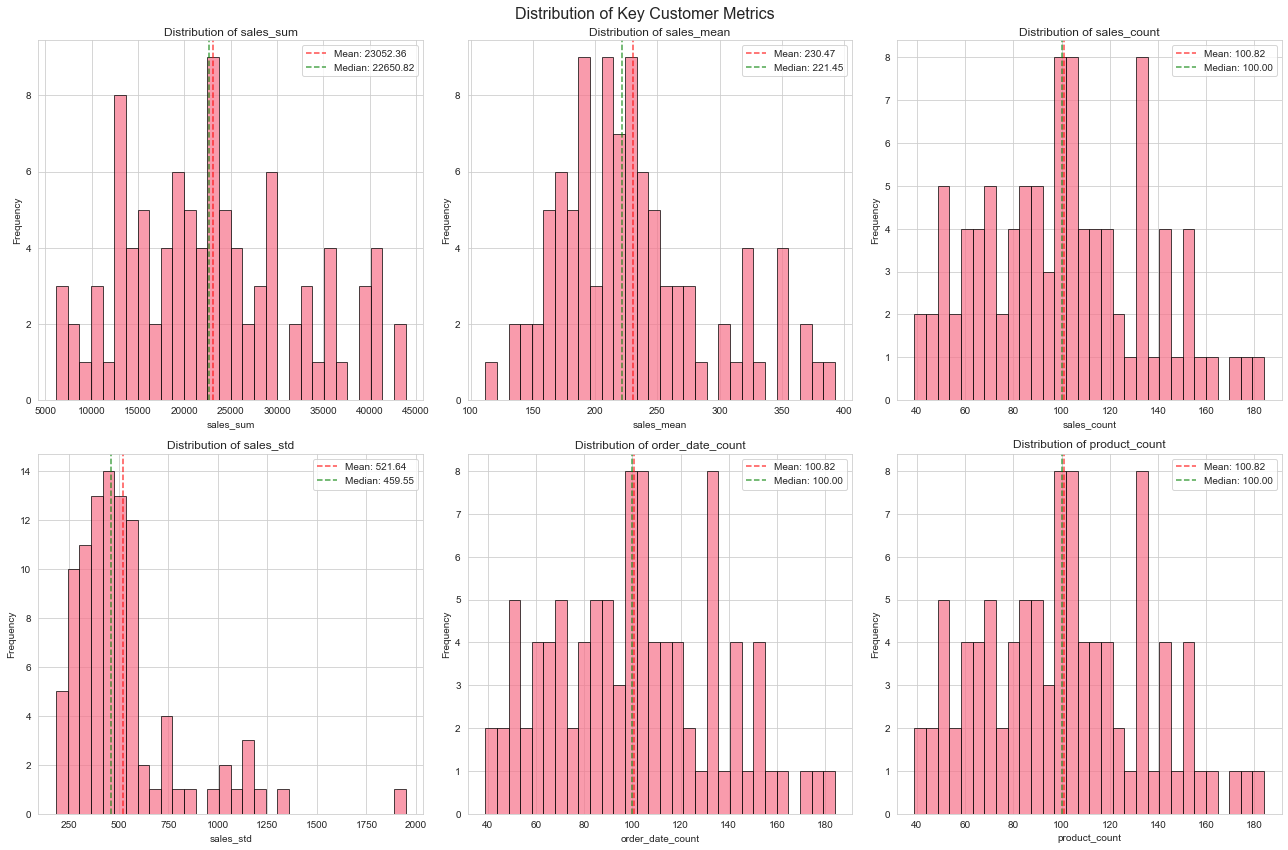

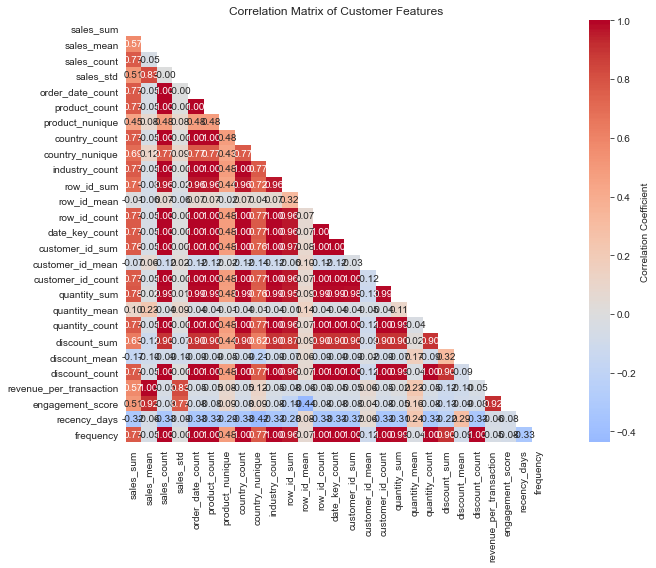


Highly correlated features (|correlation| > 0.7):
  sales_sum <-> sales_count: 0.768
  sales_sum <-> order_date_count: 0.768
  sales_sum <-> product_count: 0.768
  sales_sum <-> country_count: 0.768
  sales_sum <-> industry_count: 0.768
  sales_sum <-> row_id_sum: 0.713
  sales_sum <-> row_id_count: 0.768
  sales_sum <-> date_key_count: 0.768
  sales_sum <-> customer_id_sum: 0.765
  sales_sum <-> customer_id_count: 0.768
  sales_sum <-> quantity_sum: 0.784
  sales_sum <-> quantity_count: 0.768
  sales_sum <-> discount_count: 0.768
  sales_sum <-> frequency: 0.768
  sales_mean <-> sales_std: 0.825
  sales_mean <-> revenue_per_transaction: 1.000
  sales_mean <-> engagement_score: 0.916
  sales_count <-> order_date_count: 1.000
  sales_count <-> product_count: 1.000
  sales_count <-> country_count: 1.000
  sales_count <-> country_nunique: 0.767
  sales_count <-> industry_count: 1.000
  sales_count <-> row_id_sum: 0.963
  sales_count <-> row_id_count: 1.000
  sales_count <-> date_key_coun

In [16]:
# First, let's examine what columns we actually have
print("Available columns in customer_features:")
print(customer_features.columns.tolist())
print(f"\nDataFrame shape: {customer_features.shape}")

# Get numeric columns (excluding customer_id)
numeric_columns = customer_features.select_dtypes(include=[np.number]).columns.tolist()
if customer_id_col in numeric_columns:
    numeric_columns.remove(customer_id_col)

print(f"\nNumeric columns available for visualization: {numeric_columns}")

if len(numeric_columns) == 0:
    print("No numeric columns available for visualization!")
else:
    # Create visualizations to understand the data distribution
    # Determine the number of plots needed
    n_metrics = min(len(numeric_columns), 6)  # Show up to 6 metrics
    metrics_to_plot = numeric_columns[:n_metrics]
    
    # Calculate subplot dimensions
    if n_metrics <= 3:
        nrows, ncols = 1, n_metrics
        figsize = (6*n_metrics, 5)
    else:
        nrows = 2
        ncols = 3
        figsize = (18, 12)
    
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    fig.suptitle('Distribution of Key Customer Metrics', fontsize=16)
    
    # Handle case where we have only one subplot
    if n_metrics == 1:
        axes = [axes]
    elif nrows == 1:
        axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
    else:
        axes = axes.flatten()
    
    # Plot distributions of available metrics
    for i, metric in enumerate(metrics_to_plot):
        if i < len(axes):
            # Remove any infinite or extremely large values for better visualization
            data = customer_features[metric].replace([np.inf, -np.inf], np.nan).dropna()
            
            if len(data) > 0:
                # Use quantiles to remove extreme outliers for better visualization
                q1, q99 = data.quantile([0.01, 0.99])
                filtered_data = data[(data >= q1) & (data <= q99)]
                
                axes[i].hist(filtered_data, bins=30, alpha=0.7, edgecolor='black')
                axes[i].set_title(f'Distribution of {metric}')
                axes[i].set_xlabel(metric)
                axes[i].set_ylabel('Frequency')
                
                # Add some statistics to the plot
                mean_val = filtered_data.mean()
                median_val = filtered_data.median()
                axes[i].axvline(mean_val, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_val:.2f}')
                axes[i].axvline(median_val, color='green', linestyle='--', alpha=0.7, label=f'Median: {median_val:.2f}')
                axes[i].legend()
            else:
                axes[i].text(0.5, 0.5, 'No valid data', ha='center', va='center')
                axes[i].set_title(f'{metric} (No Data)')
    
    # Hide any unused subplots
    for i in range(n_metrics, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Correlation matrix
    if len(numeric_columns) > 1:
        plt.figure(figsize=(12, 8))
        
        # Calculate correlation matrix with cleaned data
        correlation_data = customer_features[numeric_columns].replace([np.inf, -np.inf], np.nan)
        correlation_matrix = correlation_data.corr()
        
        # Create heatmap
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Show only lower triangle
        sns.heatmap(correlation_matrix, 
                   annot=True, 
                   cmap='coolwarm', 
                   center=0,
                   mask=mask,
                   square=True,
                   fmt='.2f',
                   cbar_kws={'label': 'Correlation Coefficient'})
        plt.title('Correlation Matrix of Customer Features')
        plt.tight_layout()
        plt.show()
        
        # Print high correlations
        print("\nHighly correlated features (|correlation| > 0.7):")
        high_corr_pairs = []
        for i in range(len(correlation_matrix.columns)):
            for j in range(i+1, len(correlation_matrix.columns)):
                corr_val = correlation_matrix.iloc[i, j]
                if abs(corr_val) > 0.7:
                    high_corr_pairs.append((
                        correlation_matrix.columns[i], 
                        correlation_matrix.columns[j], 
                        corr_val
                    ))
        
        if high_corr_pairs:
            for col1, col2, corr in high_corr_pairs:
                print(f"  {col1} <-> {col2}: {corr:.3f}")
        else:
            print("  No highly correlated feature pairs found.")
    else:
        print("Need at least 2 numeric columns for correlation analysis.")
    
    # Summary statistics
    print("\n" + "="*50)
    print("SUMMARY STATISTICS")
    print("="*50)
    print(customer_features[numeric_columns].describe())
    
    # Check for potential data quality issues
    print("\n" + "="*50)
    print("DATA QUALITY CHECKS")
    print("="*50)
    
    for col in numeric_columns:
        n_missing = customer_features[col].isna().sum()
        n_infinite = np.isinf(customer_features[col]).sum()
        n_zero = (customer_features[col] == 0).sum()
        
        print(f"\n{col}:")
        print(f"  Missing values: {n_missing} ({n_missing/len(customer_features)*100:.1f}%)")
        print(f"  Infinite values: {n_infinite}")
        print(f"  Zero values: {n_zero} ({n_zero/len(customer_features)*100:.1f}%)")
        
        if customer_features[col].dtype in ['int64', 'float64']:
            print(f"  Min: {customer_features[col].min():.2f}")
            print(f"  Max: {customer_features[col].max():.2f}")
            print(f"  Mean: {customer_features[col].mean():.2f}")
            print(f"  Std: {customer_features[col].std():.2f}")

### 5: Feature Selection and Scaling

In [17]:
# Select features for clustering based on available columns
print("\nAvailable columns for clustering:")
print(customer_features.columns.tolist())

# Identify numeric columns for clustering (excluding customer ID)
numeric_features = customer_features.select_dtypes(include=[np.number]).columns.tolist()
customer_id_col = customer_features.columns[0]  # First column is customer ID

# Remove customer ID from features
if customer_id_col in numeric_features:
    numeric_features.remove(customer_id_col)

# Select top features for clustering (limit to avoid curse of dimensionality)
segmentation_features = numeric_features[:8]  # Take first 8 numeric features
print(f"Selected features for clustering: {segmentation_features}")

# Create feature matrix
X = customer_features[segmentation_features].copy()

# Handle any remaining missing values
X = X.fillna(X.median())

# Remove outliers using IQR method
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Cap outliers
for col in X.columns:
    X[col] = np.clip(X[col], lower_bound[col], upper_bound[col])

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=segmentation_features)

print("Feature scaling completed!")
print("Scaled features shape:", X_scaled_df.shape)


Available columns for clustering:
['customer', 'sales_sum', 'sales_mean', 'sales_count', 'sales_std', 'order_date_min', 'order_date_max', 'order_date_count', 'product_count', 'product_nunique', 'country_count', 'country_nunique', 'industry_count', 'row_id_sum', 'row_id_mean', 'row_id_count', 'date_key_min', 'date_key_max', 'date_key_count', 'customer_id_sum', 'customer_id_mean', 'customer_id_count', 'quantity_sum', 'quantity_mean', 'quantity_count', 'discount_sum', 'discount_mean', 'discount_count', 'revenue_per_transaction', 'engagement_score', 'recency_days', 'frequency']
Selected features for clustering: ['sales_sum', 'sales_mean', 'sales_count', 'sales_std', 'order_date_count', 'product_count', 'product_nunique', 'country_count']
Feature scaling completed!
Scaled features shape: (99, 8)


### 6: Determine Optimal Number of Clusters

Calculating optimal number of clusters...


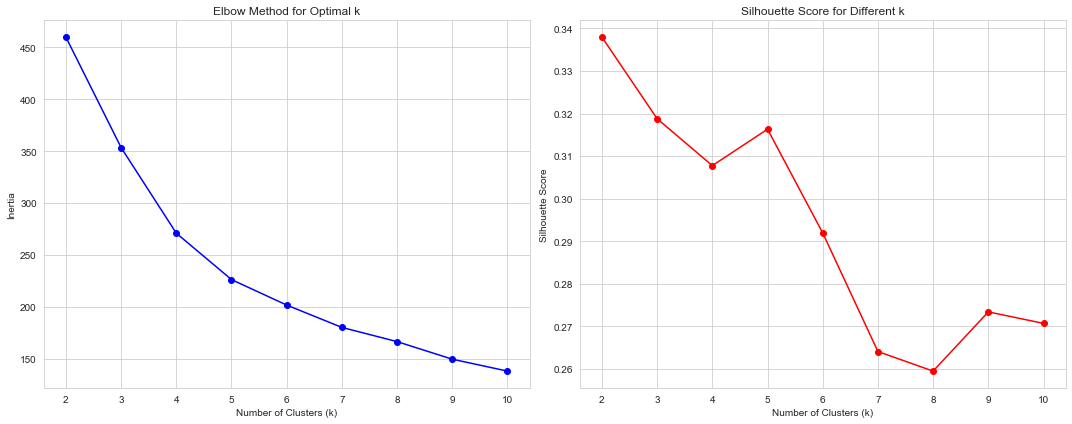

Optimal number of clusters based on silhouette score: 2


In [18]:
# Use Elbow Method and Silhouette Score
k_range = range(2, 11)
inertias = []
silhouette_scores = []

print("Calculating optimal number of clusters...")

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow Curve and Silhouette Scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Elbow Method
ax1.plot(k_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal k')
ax1.grid(True)

# Silhouette Score
ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score for Different k')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Find optimal k based on silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")

### 7: Apply K-Means Clustering

In [19]:
# Perform final clustering with optimal k
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Add cluster labels to customer features
customer_features['cluster'] = cluster_labels

print(f"K-Means clustering completed with {optimal_k} clusters")
print("Cluster distribution:")
print(customer_features['cluster'].value_counts().sort_index())

K-Means clustering completed with 2 clusters
Cluster distribution:
0    47
1    52
Name: cluster, dtype: int64


### 8: Cluster Analysis and Profiling

In [20]:
# Calculate cluster profiles using available features
cluster_profiles = customer_features.groupby('cluster')[segmentation_features].agg(['mean', 'median']).round(2)

print("\nCluster Profiles:")
print(cluster_profiles)

# Create cluster summary table with available features
summary_features = segmentation_features[:4]  # Use first 4 features for summary
cluster_summary = customer_features.groupby('cluster').agg({
    customer_id_col: 'count',
    **{feature: 'mean' for feature in summary_features}
}).round(2)

cluster_summary.columns = ['Customer_Count'] + [f'Avg_{feature}' for feature in summary_features]

print("\nCluster Summary:")
print(cluster_summary)


Cluster Profiles:
        sales_sum           sales_mean         sales_count        sales_std  \
             mean    median       mean  median        mean median      mean   
cluster                                                                       
0        30792.65  29783.46     238.78  227.23      130.83  131.0    567.32   
1        16345.12  15809.56     224.06  209.79       73.94   76.5    503.75   

                order_date_count        product_count        product_nunique  \
         median             mean median          mean median            mean   
cluster                                                                        
0        501.40           130.83  131.0        130.83  131.0           13.19   
1        422.75            73.94   76.5         73.94   76.5           12.31   

               country_count         
        median          mean median  
cluster                              
0         13.0        130.83  131.0  
1         12.0         73.94   7

### 9: Cluster Visualization

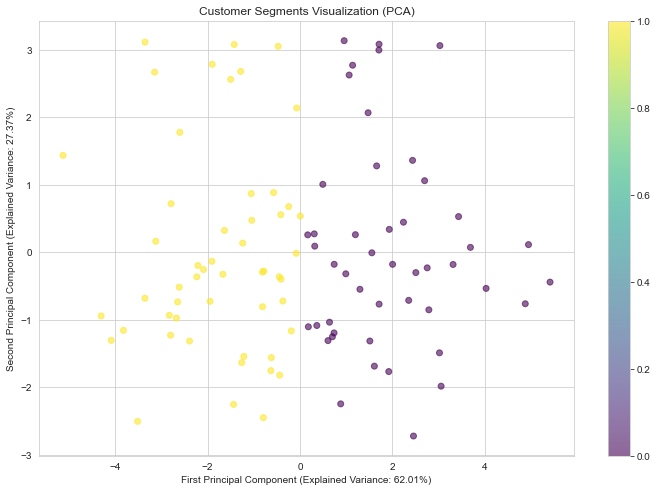

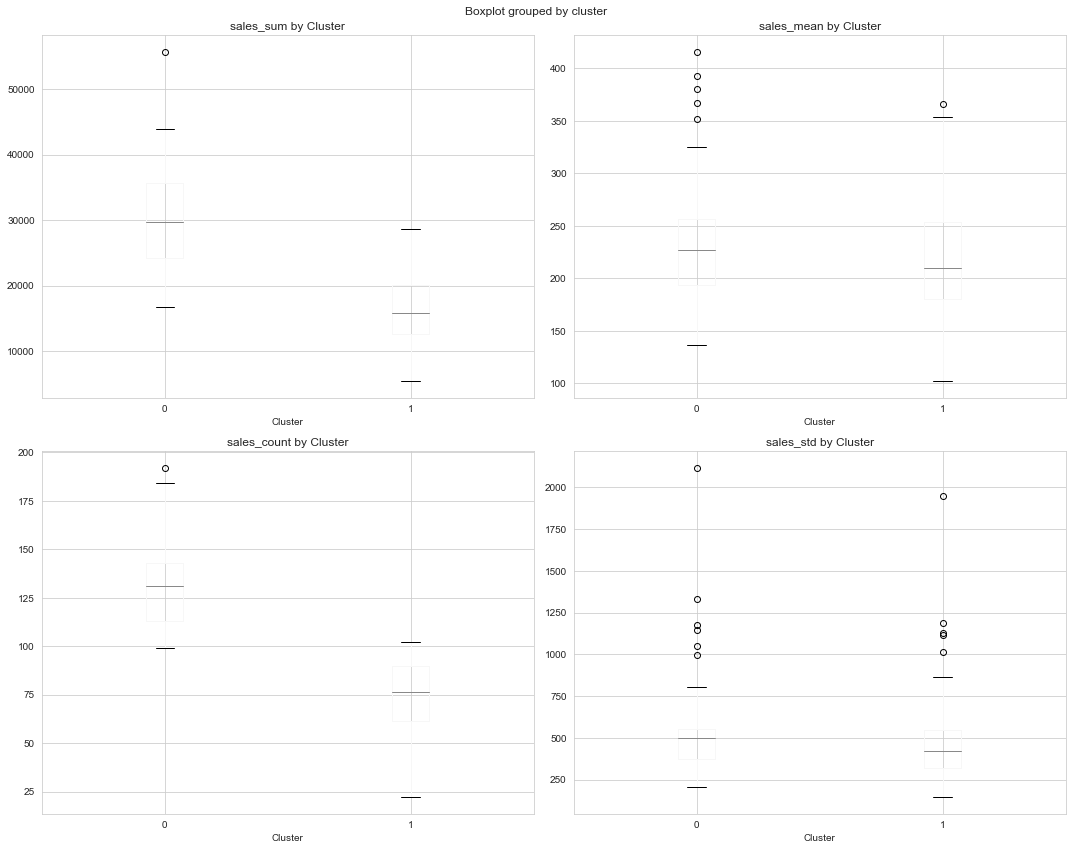

In [21]:
# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create scatter plot of clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.xlabel(f'First Principal Component (Explained Variance: {pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'Second Principal Component (Explained Variance: {pca.explained_variance_ratio_[1]:.2%})')
plt.title('Customer Segments Visualization (PCA)')
plt.show()

# Box plots for key metrics by cluster
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Key Metrics by Customer Segment', fontsize=16)

# Use first 4 available features for plotting
metrics_to_plot = segmentation_features[:4]

for i, metric in enumerate(metrics_to_plot):
    row = i // 2
    col = i % 2
    customer_features.boxplot(column=metric, by='cluster', ax=axes[row, col])
    axes[row, col].set_title(f'{metric} by Cluster')
    axes[row, col].set_xlabel('Cluster')

plt.tight_layout()
plt.show()

### 10: Segment Interpretation and Naming

In [22]:
# Define segment characteristics based on cluster analysis
segment_names = {}
segment_descriptions = {}

# Get the primary metrics for analysis (use first few features)
primary_metrics = segmentation_features[:3]
print(f"Using primary metrics for segmentation: {primary_metrics}")

# Analyze each cluster to assign meaningful names
for cluster_id in range(optimal_k):
    cluster_data = customer_features[customer_features['cluster'] == cluster_id]
    
    # Calculate percentiles for the primary metrics
    metric_percentiles = {}
    for metric in primary_metrics:
        if metric in customer_features.columns:
            cluster_value = cluster_data[metric].mean()
            overall_percentile = (customer_features[metric] <= cluster_value).mean()
            metric_percentiles[metric] = overall_percentile
    
    # Create segment names based on performance across metrics
    high_performers = sum(1 for p in metric_percentiles.values() if p > 0.75)
    medium_performers = sum(1 for p in metric_percentiles.values() if 0.25 <= p <= 0.75)
    low_performers = sum(1 for p in metric_percentiles.values() if p < 0.25)
    
    if high_performers >= 2:
        segment_names[cluster_id] = f"High-Performance Segment {cluster_id}"
        segment_descriptions[cluster_id] = "High-value customers with strong engagement"
    elif medium_performers >= 2:
        segment_names[cluster_id] = f"Medium-Performance Segment {cluster_id}"
        segment_descriptions[cluster_id] = "Moderate-value customers with average engagement"
    else:
        segment_names[cluster_id] = f"Low-Performance Segment {cluster_id}"
        segment_descriptions[cluster_id] = "Lower-value customers requiring attention"

# Create final segmentation results
customer_features['segment_name'] = customer_features['cluster'].map(segment_names)
customer_features['segment_description'] = customer_features['cluster'].map(segment_descriptions)

print("\nFinal Customer Segments:")
for cluster_id in range(optimal_k):
    count = len(customer_features[customer_features['cluster'] == cluster_id])
    print(f"Cluster {cluster_id}: {segment_names[cluster_id]} ({count} customers)")
    print(f"  Description: {segment_descriptions[cluster_id]}")
    print()

Using primary metrics for segmentation: ['sales_sum', 'sales_mean', 'sales_count']

Final Customer Segments:
Cluster 0: High-Performance Segment 0 (47 customers)
  Description: High-value customers with strong engagement

Cluster 1: Medium-Performance Segment 1 (52 customers)
  Description: Moderate-value customers with average engagement



### 11: Business Insights and Recommendations

In [23]:
print("=== BUSINESS INSIGHTS AND RECOMMENDATIONS ===")
print()

# Calculate segment sizes and percentages
segment_analysis = customer_features.groupby('segment_name').agg({
    customer_id_col: 'count',
    **{feature: 'mean' for feature in segmentation_features[:3]}
}).round(2)

segment_analysis['percentage'] = (segment_analysis[customer_id_col] / len(customer_features) * 100).round(1)

print("Segment Analysis:")
print(segment_analysis)
print()

# Generate actionable recommendations
recommendations = {
    "High-Value Power Users": [
        "Implement premium support tiers",
        "Offer advanced features and integrations",
        "Create loyalty programs with exclusive benefits",
        "Assign dedicated account managers"
    ],
    "High-Value Casual Users": [
        "Focus on increasing engagement through targeted campaigns",
        "Provide usage analytics and insights",
        "Offer training sessions to maximize platform utilization",
        "Implement usage-based pricing incentives"
    ],
    "Mid-Value Active Users": [
        "Implement growth strategies to move them to high-value segments",
        "Offer feature upgrades and add-ons",
        "Provide regular check-ins and best practice sharing",
        "Create referral programs"
    ],
    "Mid-Value Occasional Users": [
        "Investigate barriers to increased usage",
        "Implement re-engagement campaigns",
        "Offer usage tutorials and onboarding support",
        "Consider feature simplification"
    ],
    "High-Maintenance Users": [
        "Invest in improved onboarding and documentation",
        "Implement self-service support options",
        "Consider pricing adjustments for support-heavy users",
        "Identify common issues and improve product stability"
    ],
    "Low-Value Users": [
        "Implement retention strategies",
        "Evaluate churn risk and prevention measures",
        "Consider cost-effective acquisition channels",
        "Explore freemium or trial upgrade paths"
    ]
}

for segment_name, recs in recommendations.items():
    if segment_name in customer_features['segment_name'].values:
        print(f"Recommendations for {segment_name}:")
        for i, rec in enumerate(recs, 1):
            print(f"  {i}. {rec}")
        print()

=== BUSINESS INSIGHTS AND RECOMMENDATIONS ===

Segment Analysis:
                              customer  sales_sum  sales_mean  sales_count  \
segment_name                                                                 
High-Performance Segment 0          47   30792.65      238.78       130.83   
Medium-Performance Segment 1        52   16345.12      224.06        73.94   

                              percentage  
segment_name                              
High-Performance Segment 0          47.5  
Medium-Performance Segment 1        52.5  



### 12: Export Results

In [24]:
# Save customer segmentation results
customer_segmentation_results = customer_features[[
    customer_id_col, 'cluster', 'segment_name', 'segment_description'
] + segmentation_features[:4]]

# Save to CSV
customer_segmentation_results.to_csv('customer_segmentation_results.csv', index=False)
print("Customer segmentation results saved to 'customer_segmentation_results.csv'")

# Save cluster profiles
cluster_profiles.to_csv('cluster_profiles.csv')
print("Cluster profiles saved to 'cluster_profiles.csv'")

# Save segment analysis
segment_analysis.to_csv('segment_analysis.csv')
print("Segment analysis saved to 'segment_analysis.csv'")

print("\n=== USER SEGMENTATION ANALYSIS COMPLETED ===")
print(f"Total customers analyzed: {len(customer_features)}")
print(f"Number of segments created: {optimal_k}")
print(f"Silhouette score: {max(silhouette_scores):.3f}")
print("All results have been saved to CSV files for further analysis.")

Customer segmentation results saved to 'customer_segmentation_results.csv'
Cluster profiles saved to 'cluster_profiles.csv'
Segment analysis saved to 'segment_analysis.csv'

=== USER SEGMENTATION ANALYSIS COMPLETED ===
Total customers analyzed: 99
Number of segments created: 2
Silhouette score: 0.338
All results have been saved to CSV files for further analysis.
